### Loan Approval Prediction 


In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams["figure.figsize"] = (6,5)

import warnings
warnings.filterwarnings("ignore")

# Data visualization

In [74]:
dataset = pd.read_csv('loan_dataset.csv')
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [75]:
dataset.shape

(614, 13)

In [76]:
dataset.info

<bound method DataFrame.info of       Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001002    Male      No          0      Graduate            No   
1    LP001003    Male     Yes          1      Graduate            No   
2    LP001005    Male     Yes          0      Graduate           Yes   
3    LP001006    Male     Yes          0  Not Graduate            No   
4    LP001008    Male      No          0      Graduate            No   
..        ...     ...     ...        ...           ...           ...   
609  LP002978  Female      No          0      Graduate            No   
610  LP002979    Male     Yes         3+      Graduate            No   
611  LP002983    Male     Yes          1      Graduate            No   
612  LP002984    Male     Yes          2      Graduate            No   
613  LP002990  Female      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               5849          

In [77]:
# gives the info for numerical columns
dataset.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


<AxesSubplot:>

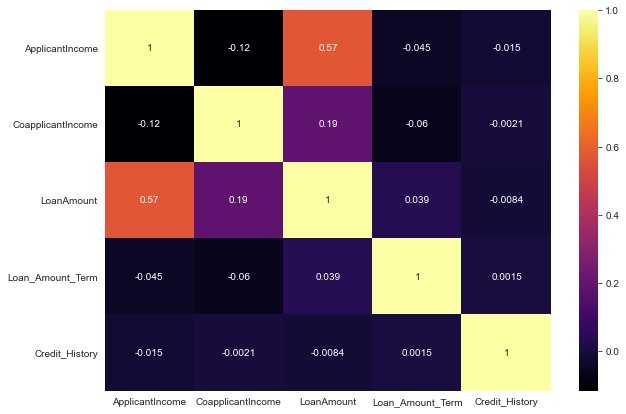

In [78]:
plt.figure(figsize=(10,7))
sns.heatmap(dataset[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']].corr(), annot=True, cmap='inferno') 

<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

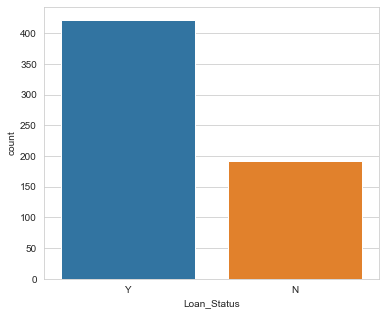

In [79]:
# check if the data is imbalanced
sns.set_style('whitegrid')
sns.countplot(x='Loan_Status',data=dataset)

In [80]:
# see the chart in details
dataset['Loan_Status'].value_counts()/len(dataset)*100


Y    68.729642
N    31.270358
Name: Loan_Status, dtype: float64

In [81]:
# check if we have null values
dataset.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [82]:
# divide the numerical from categorical features

numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))
print(numerical_features)

Number of numerical variables:  5
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [83]:
# numerical is divided in discrete and continuous

df=dataset
discrete_features=[feature for feature in numerical_features if len(df[feature].unique())<15]
print("Discrete Variables Count: {}".format(len(discrete_features)))
print(discrete_features)

Discrete Variables Count: 2
['Loan_Amount_Term', 'Credit_History']


In [84]:
df['Loan_Amount_Term'].unique()

array([360., 120., 240.,  nan, 180.,  60., 300., 480.,  36.,  84.,  12.])

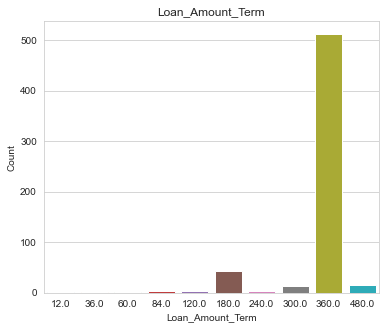

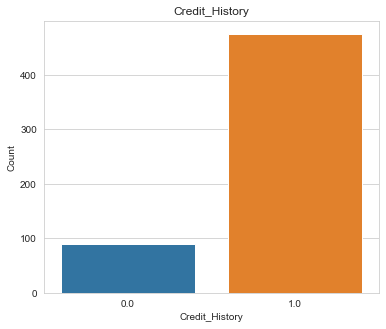

In [85]:
# plot the absolute frequencies for each feature
sns.set_style('whitegrid')

for feature in discrete_features:
    sns.countplot(x=feature, data=df)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

    print()

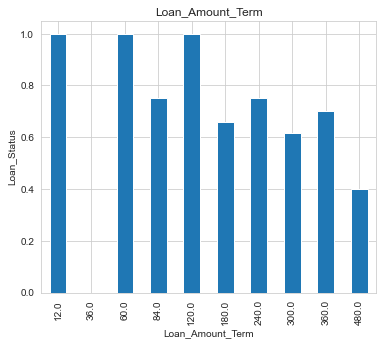

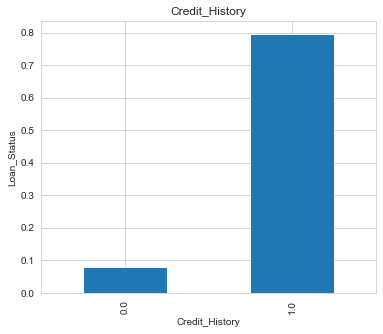

In [86]:
#substitute the target values with 1 and 0
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1,'N' : 0})

for feature in discrete_features:
    data=df.copy()
    data.groupby(feature)['Loan_Status'].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Loan_Status')
    plt.title(feature)
    plt.show()

In [87]:
# continuous features

continuous_feature=[feature for feature in numerical_features if feature not in discrete_features]
print("Continuous feature Count {}".format(len(continuous_feature)))
print(continuous_feature)

Continuous feature Count 3
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


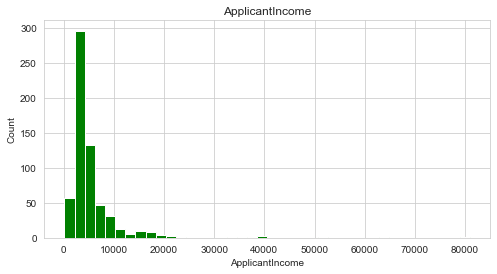

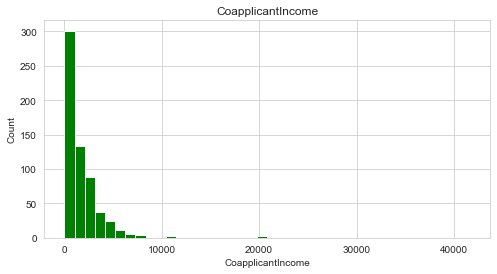

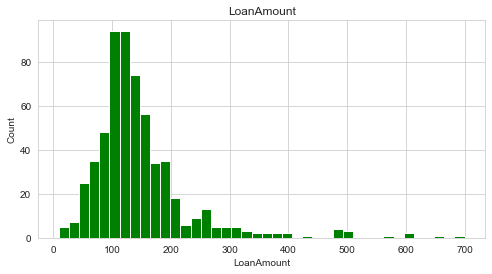

5403.459283387622
3812.5


In [88]:
for feature in continuous_feature:
    data=df.copy()
    data[feature].hist(color='green',bins=40,figsize=(8,4)) 
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()
    
print(df['ApplicantIncome'].mean())
print(df['ApplicantIncome'].median())

# normal dist- mean and median are close to each-other
# right skewed-  MEAN > MEDIAN
# left skewed - MEAN < MEDIAN

# first graph - more skewed than normal
# second - skewed to the right
# third is close to a normal distribution

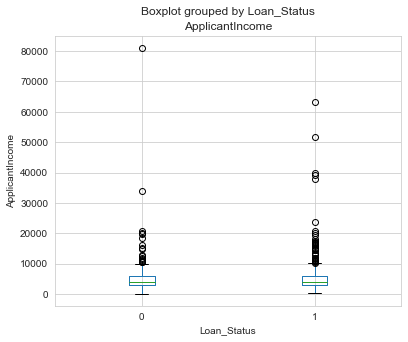

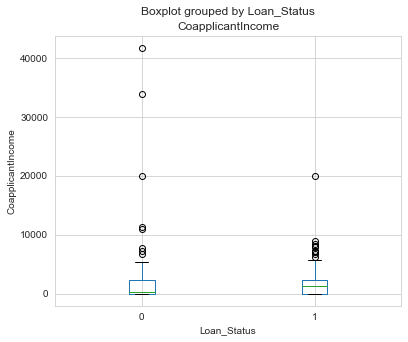

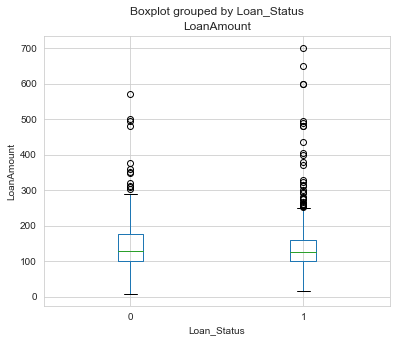

In [89]:
# boxplot every continuous feature
#group every feature according to the target

# first plot - same level 

for feature in continuous_feature:
    data=df.copy()
    data.boxplot(column=feature, by='Loan_Status')
    plt.xlabel('Loan_Status')
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

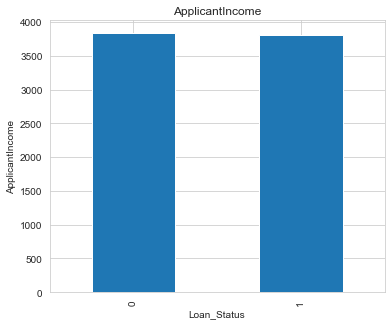

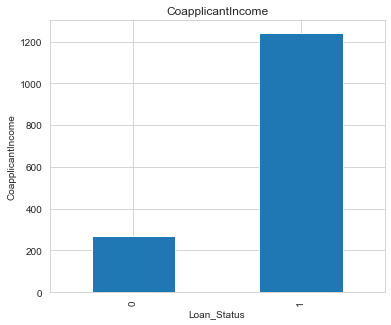

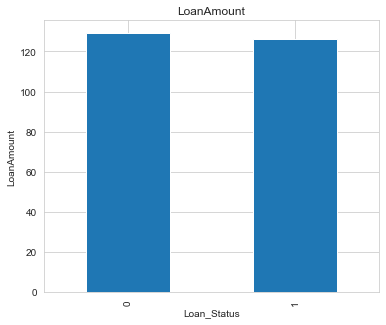

In [90]:
# I chose median as the dataset has outliers
for feature in continuous_feature:
    data=df.copy()
    data.groupby('Loan_Status')[feature].median().plot.bar()
    plt.xlabel('Loan_Status')
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

In [91]:
# categorical variables 

categorical_features=[feature for feature in df.columns if df[feature].dtypes=='O' and feature not in ['Loan_ID']]
print(len(categorical_features))
print(categorical_features)


6
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [92]:
for feature in categorical_features:
    print(f'Feature {feature} - Number of Categories {len(df[feature].unique())}')

Feature Gender - Number of Categories 3
Feature Married - Number of Categories 3
Feature Dependents - Number of Categories 5
Feature Education - Number of Categories 2
Feature Self_Employed - Number of Categories 3
Feature Property_Area - Number of Categories 3


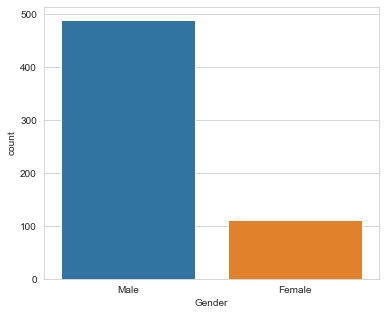

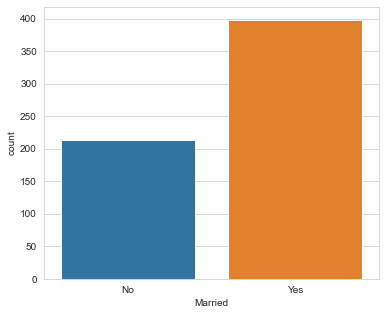

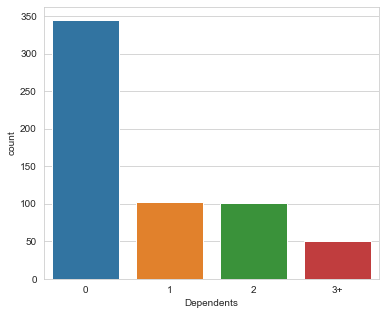

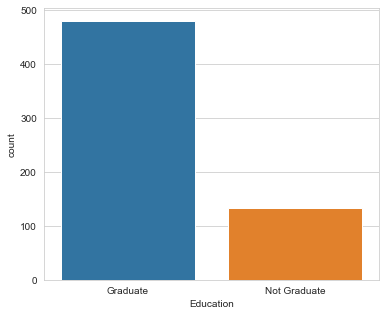

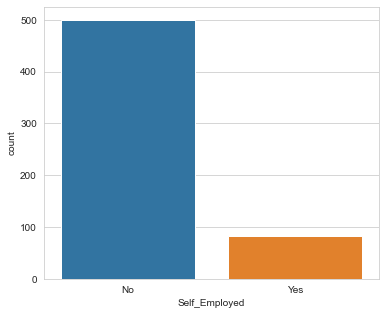

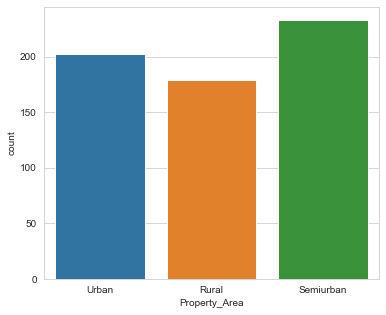

In [93]:
#Frequencies for each category
for feature in categorical_features:
    data=df.copy()      
    sns.countplot(x=feature, data=data)
    plt.show()

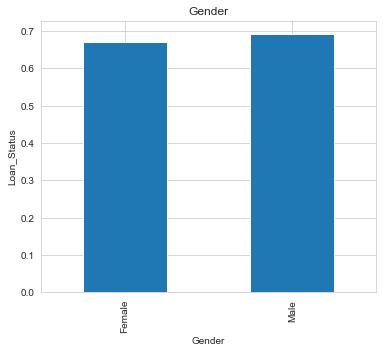

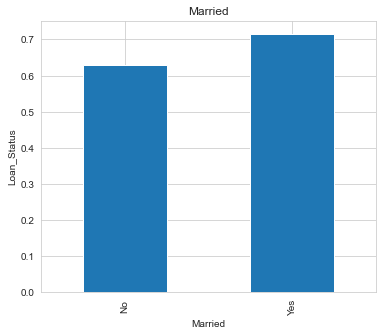

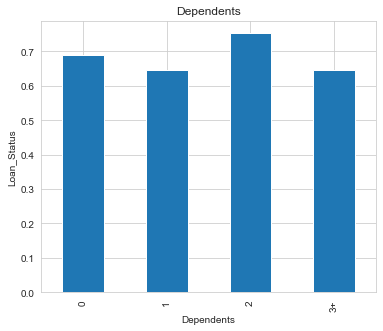

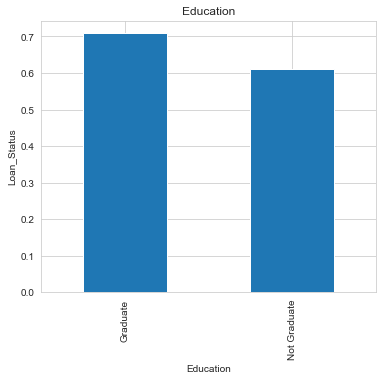

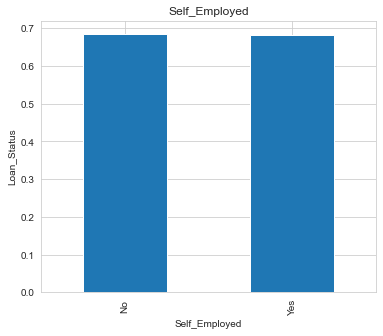

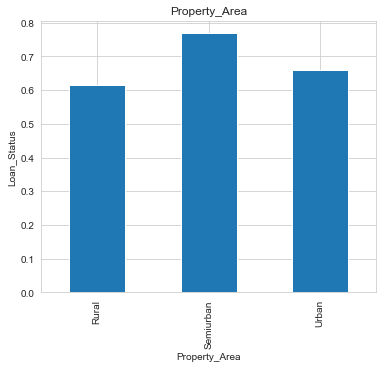

In [94]:
# frequencies for each category, grouped by loan status
for feature in categorical_features:

    data=df.copy()
    data.groupby(feature)['Loan_Status'].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Loan_Status')
    plt.title(feature)
    plt.show()   

    print()

# Data pre-processing

In [95]:
# we drop ID column

df.drop(columns='Loan_ID',axis=1,inplace=True)

In [96]:
# check for missing values

df.isnull().sum()/len(df)*100


Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [97]:
print(discrete_features)

['Loan_Amount_Term', 'Credit_History']


In [98]:
# we substitute it with mode because it's a discrete feature
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])

In [99]:
# we substitute it with mode because it's a discrete feature
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])

In [100]:
# continuous features
print(continuous_feature)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


<AxesSubplot:xlabel='LoanAmount'>

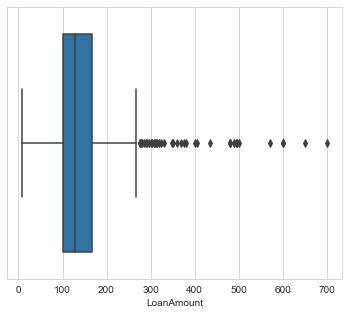

In [101]:
sns.boxplot(x='LoanAmount',data=df)

In [102]:
# since it has so many outliers, we use median
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())

In [103]:
# categorical features
print(categorical_features)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [104]:
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])

In [105]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [106]:
# Encoding categorical features
df = pd.get_dummies(df, columns=categorical_features)
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,128.0,360.0,1.0,1,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1
1,4583,1508.0,128.0,360.0,1.0,0,0,1,0,1,...,1,0,0,1,0,1,0,1,0,0
2,3000,0.0,66.0,360.0,1.0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1
3,2583,2358.0,120.0,360.0,1.0,1,0,1,0,1,...,0,0,0,0,1,1,0,0,0,1
4,6000,0.0,141.0,360.0,1.0,1,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1


In [107]:
# dropping meaningless features
df = df.drop(['Gender_Female', 'Married_No', 'Education_Not Graduate', 
              'Self_Employed_No'], axis = 1)

# keep only one-hot encoded
new = {'Gender_Male': 'Gender', 'Married_Yes': 'Married', 
       'Education_Graduate': 'Education', 'Self_Employed_Yes': 'Self_Employed'
      }

df.rename(columns=new, inplace=True)

#Square Root Transformation
df.ApplicantIncome = np.sqrt(df.ApplicantIncome)
df.CoapplicantIncome = np.sqrt(df.CoapplicantIncome)
df.LoanAmount = np.sqrt(df.LoanAmount)

In [108]:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender,Married,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education,Self_Employed,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,76.478755,0.000000,11.313708,360.0,1.0,1,1,0,1,0,0,0,1,0,0,0,1
1,67.697858,38.832976,11.313708,360.0,1.0,0,1,1,0,1,0,0,1,0,1,0,0
2,54.772256,0.000000,8.124038,360.0,1.0,1,1,1,1,0,0,0,1,1,0,0,1
3,50.823223,48.559242,10.954451,360.0,1.0,1,1,1,1,0,0,0,0,0,0,0,1
4,77.459667,0.000000,11.874342,360.0,1.0,1,1,0,1,0,0,0,1,0,0,0,1


### Feature Scaling & Train-validation-test

In [109]:
X = df.drop('Loan_Status', axis=1)
Y = df['Loan_Status']
X_train,X_test, Y_train, Y_test =train_test_split(X,Y,random_state=0, test_size=0.2)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = pd.DataFrame(data=X_train, columns=X.columns)

In [110]:
Y_train.value_counts()

1    332
0    159
Name: Loan_Status, dtype: int64

### PCA - eleminates unimportant/unecessary features 
They are applied with the condition that the features must be scaled.

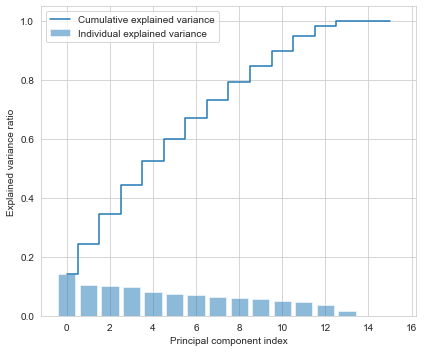

In [111]:
pca = PCA()

# Determine transformed features

X_pca = pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')

plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [112]:
dic = {}

for nr_princ_comp in range(1, 15):
    for n_n in range(1,21):
        pca = PCA(n_components=nr_princ_comp, random_state=0)
        X_train_pca = pca.fit_transform(X_train)
        knn = KNeighborsClassifier(n_neighbors=n_n)
        knn.fit(X_train_pca, Y_train)
        
        X_test_pca = pca.transform(X_test)
        pred_test = knn.predict(X_test_pca)
        auc_score = roc_auc_score(Y_test, pred_test)
        dic[(nr_princ_comp, n_n)] = auc_score

In [113]:
for (nr_princ_comp, n_n), auc_score in dic.items():
    print(f'(Nr_Princ_Comp , N_Neighbors) : {(nr_princ_comp, n_n)} -- AUC Score : {auc_score}')

(Nr_Princ_Comp , N_Neighbors) : (1, 1) -- AUC Score : 0.4919191919191919
(Nr_Princ_Comp , N_Neighbors) : (1, 2) -- AUC Score : 0.503030303030303
(Nr_Princ_Comp , N_Neighbors) : (1, 3) -- AUC Score : 0.47525252525252526
(Nr_Princ_Comp , N_Neighbors) : (1, 4) -- AUC Score : 0.445959595959596
(Nr_Princ_Comp , N_Neighbors) : (1, 5) -- AUC Score : 0.46616161616161617
(Nr_Princ_Comp , N_Neighbors) : (1, 6) -- AUC Score : 0.4767676767676768
(Nr_Princ_Comp , N_Neighbors) : (1, 7) -- AUC Score : 0.48282828282828283
(Nr_Princ_Comp , N_Neighbors) : (1, 8) -- AUC Score : 0.4797979797979798
(Nr_Princ_Comp , N_Neighbors) : (1, 9) -- AUC Score : 0.46515151515151515
(Nr_Princ_Comp , N_Neighbors) : (1, 10) -- AUC Score : 0.4787878787878788
(Nr_Princ_Comp , N_Neighbors) : (1, 11) -- AUC Score : 0.5025252525252525
(Nr_Princ_Comp , N_Neighbors) : (1, 12) -- AUC Score : 0.49696969696969695
(Nr_Princ_Comp , N_Neighbors) : (1, 13) -- AUC Score : 0.49292929292929294
(Nr_Princ_Comp , N_Neighbors) : (1, 14) -- 

In [114]:
# Best parameters (components and neighbors) for only KNN model
# other models works best using PCA(n_components=0.90)
n_components, n_neighbors = max(dic, key=dic.get)
print("auc score", dic[(n_components, n_neighbors)])
print("components", n_components)
print("neighbors", n_neighbors)

auc score 0.7065656565656566
components 11
neighbors 14


In [115]:
X_train.shape

(491, 16)

In [116]:
pca = PCA(n_components=0.90, random_state = 0)
X_new = pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.14016912 0.10341561 0.10121114 0.09755061 0.08237967 0.07406375
 0.07100184 0.06391005 0.05950124 0.05536783 0.05131308 0.04837278]
0.9482567114192371


In [117]:
X_train.shape

(491, 12)

In [118]:
Y_train.value_counts()

1    332
0    159
Name: Loan_Status, dtype: int64

## SMOTE

In [119]:
smote = SMOTE(random_state=0)
X_train, Y_train = smote.fit_resample(X_train, Y_train)
Y_train

0      1
1      0
2      0
3      1
4      1
      ..
659    0
660    0
661    0
662    0
663    0
Name: Loan_Status, Length: 664, dtype: int64

In [120]:
# check if it is balanced
Y_train.value_counts()

0    332
1    332
Name: Loan_Status, dtype: int64

array([[-0.49365517, -0.13037993, -0.6242737 , ..., -0.03083136,
        -0.26491953,  0.14533456],
       [ 0.84541904,  2.07397929, -1.6286172 , ..., -0.8693729 ,
        -1.13586537, -0.78088895],
       [-0.1784536 , -0.4103148 ,  2.13103154, ..., -1.17321249,
         0.30036881,  0.89056459],
       ...,
       [ 2.73117848,  1.1012561 , -0.11388807, ...,  0.25445983,
         1.46140685,  0.37811982],
       [-0.45058218, -1.0502389 ,  2.17585787, ..., -0.49337833,
         0.42121716, -0.83224413],
       [-1.84340964, -0.12592435,  0.23512962, ..., -0.00309164,
        -0.81692433,  0.35275712]])

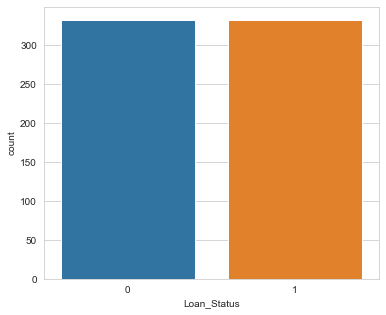

In [121]:
sns.set_style('whitegrid')
sns.countplot(x='Loan_Status',data={ "Loan_Status": Y_train })
X_train

# K-Nearest Neighbors

In [122]:
# default number of neighbours=5
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [123]:
pred = knn.predict(X_test)
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.41      0.55      0.47        33
           1       0.81      0.71      0.76        90

    accuracy                           0.67       123
   macro avg       0.61      0.63      0.61       123
weighted avg       0.70      0.67      0.68       123



In [124]:
roc = roc_auc_score(Y_test, pred)
print(roc)

0.6282828282828283


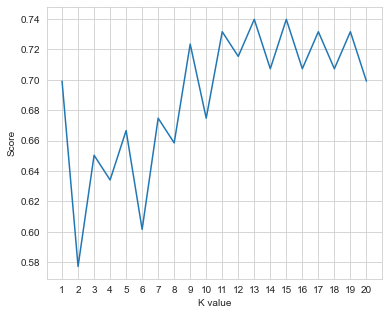

KNN best accuracy: 73.98%


In [125]:
## Hyperparameter tuning

scoreListknn = []
for i in range(1,21):
    KNclassifier = KNeighborsClassifier(n_neighbors = i)
    KNclassifier.fit(X_train, Y_train)
    scoreListknn.append(KNclassifier.score(X_test, Y_test))
    
plt.plot(range(1,21), scoreListknn)
plt.xticks(np.arange(1,21,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()
KNAcc = max(scoreListknn)
print("KNN best accuracy: {:.2f}%".format(KNAcc*100))


In test set, which is imbalanced we must not use accuracy score, even if the accuracy would result high.

In [126]:
# create a new model with no. of neighbour 13

KNclassifier = KNeighborsClassifier(n_neighbors = 13)
KNclassifier.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=13)

In [127]:
pred = KNclassifier.predict(X_test)
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.51      0.64      0.57        33
           1       0.85      0.78      0.81        90

    accuracy                           0.74       123
   macro avg       0.68      0.71      0.69       123
weighted avg       0.76      0.74      0.75       123



# Gaussian Naive Bayes

In [128]:
# Gaussian classifier
NBclassifier = GaussianNB(var_smoothing=0.9202966808760416)
NBclassifier.fit(X_train, Y_train)

GaussianNB(var_smoothing=0.9202966808760416)

In [129]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=500)}
gs_NB = GridSearchCV(estimator=NBclassifier, 
                 param_grid=params_NB, 
                 verbose=1,
                 refit=True, 
                 scoring='f1',
                 n_jobs=-1)

gs_NB.fit(X_train, Y_train)
gs_NB.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


{'var_smoothing': 0.9202966808760416}

# Logistic Regression

In [130]:
LRclassifier = LogisticRegression(C = 1.0, solver = 'liblinear', random_state = 42)
LRclassifier.fit(X_train, Y_train)



LogisticRegression(random_state=42, solver='liblinear')

In [131]:
from sklearn.model_selection import GridSearchCV
paramsLR = {'solver':['liblinear', 'saga', 'newton-cg', 'saga', 'sag', 'lbfgs'], 'C': np.arange (1, 100, 0.3) }
gsLR = GridSearchCV(estimator=LRclassifier, 
                     param_grid=paramsLR, 
                     verbose=1,
                     refit=False, 
                     scoring='f1', 
                     n_jobs=-1)
gsLR.fit(X_train, Y_train)
gsLR.best_params_

Fitting 5 folds for each of 1980 candidates, totalling 9900 fits


{'C': 1.0, 'solver': 'liblinear'}

# Support Vector Machine


In [132]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

svc_grid_search = GridSearchCV(estimator=SVC(),param_grid=param_grid,verbose=1, refit=True, scoring='f1', n_jobs=-1)
svc_grid_search.fit(X_train,Y_train)

print(svc_grid_search.best_estimator_)
print(svc_grid_search.best_params_)
print()

svc_classifier = SVC(C=100, gamma=1, kernel='poly');
svc_classifier.fit(X_train,Y_train);

Y_pred = svc_grid_search.predict(X_test)
print(confusion_matrix(Y_test,Y_pred))
print(classification_report(Y_test,Y_pred))

svc_classifier = SVC(C= 100, gamma= 1, kernel= 'rbf', probability=True)
svc_classifier.fit(X_train,Y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
SVC(C=1, gamma=1)
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

[[12 21]
 [19 71]]
              precision    recall  f1-score   support

           0       0.39      0.36      0.38        33
           1       0.77      0.79      0.78        90

    accuracy                           0.67       123
   macro avg       0.58      0.58      0.58       123
weighted avg       0.67      0.67      0.67       123



SVC(C=100, gamma=1, probability=True)

# Metrics

In [141]:
def build_auc_plot(classifiers, X_data, y_data):
    fig, ax = plt.subplots()

    for classifier in classifiers:
        model_name = type(classifier).__name__
        y_pred = classifier.predict(X_data)
        y_pred_proba = classifier.predict_proba(X_data)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_data,  y_pred_proba)
    
        auc2 =  roc_auc_score(y_data, y_pred)
        # auc = metrics.roc_auc_score(y_data, y_pred_proba)
        plt.plot(fpr,tpr,label=f"{model_name}, auc={int(round(auc2*100))}%")

    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.show()

def show_details(X_data, y_data, classifier, cv):
    y_pred = classifier.predict(X_data)
    model_name = type(classifier).__name__

    scores = cross_val_score(classifier, X, Y, cv=cv)
    class_report = classification_report(y_data, y_pred)
    confusion = confusion_matrix(y_data, y_pred)
    roc = roc_auc_score(y_data, y_pred)

    print(f" {model_name} ".center(60, "="))

    print(class_report)
    print(confusion)
    print(f"{model_name} roc: {roc*100:.2f}%")
    print(scores)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["non approved", "approved"])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    build_auc_plot([classifier], X_data, y_data)

    print("\n\n")

In [142]:
def create_report(X_data, y_data, classifiers, cv=5):
    report = {}
  
    for classifier in classifiers:
        y_pred = classifier.predict(X_data)
        model_name = type(classifier).__name__

        report[model_name] = {}
        report[model_name]['roc'] = roc_auc_score(y_data, y_pred)
        report[model_name]['confusion_matrix'] = confusion_matrix(y_data, y_pred)
        report[model_name]['cross_val'] = cross_val_score(classifier, X, Y, cv=cv)
        report[model_name]['metrics'] = classification_report(y_data, y_pred, output_dict=True)

    return report

In [143]:
def build_cell(component, width=31):
    if type(component) == str:
        return component.center(width)
    elif type(component) == int:
        return f"{component}".center(width)
    elif type(component) == np.float64 or type(component) == float:
        return f"{component*100:.2f}%".center(width)
    elif type(component) == list or type(component) == set:
        return "|".join(map(lambda x: build_cell(x, width=width//len(component)), component))
    else:
        print(component)
        print(type(component))

def build_row(components, width=31):
    center = "|".join([build_cell(component, width=width) for component in components])
    row = f"|{center}|"
    return row

def build_table(rows, heading=None):
    if not rows:
        return ""
  
    rows = list(map(lambda x: build_row(x), rows))
    row_separator = "-" * len(rows[0])
    output = row_separator + "\n"

    if heading:
        output += build_row([ heading ], width=len(rows[0]) - 2) + "\n" + row_separator + "\n"

    for row in rows:
        output += row + "\n" + row_separator + "\n"

    return output

def render_confusion_matrix(cf):
    return f"{cf[0][0]} {cf[0][1]} - {cf[1][0]} {cf[1][1]}"

def render_cross_val(cv):
    return f"{cv.mean()*100:.2f}% ({cv.std():.2f})"
  
def print_report(name, report):
    cv = len(list(report.values())[0]['cross_val'])

    rows = [
        [ '-', 'precision', 'recall', 'f1-score', 'support', 'roc', 'confusion matrix', f'cross val (cv={cv})' ],
        [ '(class)', ['0', '1'], ['0', '1'], ['0', '1'], ['0', '1'], '-', '-', '-' ]
  ]

    for model_name, data in report.items():
        metrics = [ [ data['metrics'][c][metric] for c in [ '0', '1' ] ] for metric in [ 'precision', 'recall', 'f1-score', 'support' ] ]
        row = [model_name, *metrics, data['roc'], render_confusion_matrix(data['confusion_matrix']), render_cross_val(data['cross_val'])]
        rows.append(row)

    print(build_table(rows, heading=name))

In [144]:
# testing parameters
classifiers = [ NBclassifier, knn, LRclassifier, svc_classifier ]

# see cv parameter
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score
cv_generator = 6

In [145]:
report = create_report(X_train, Y_train, classifiers, cv=cv_generator)
print_report("training set", report)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|                                                                                                                          training set                                                                                                                         |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|               -               |           precision           |             recall            |            f1-score           |            support            |              roc              |        confusion matrix       | 

In [146]:
report = create_report(X_test, Y_test, classifiers, cv=cv_generator)
print_report("test set", report)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|                                                                                                                            test set                                                                                                                           |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|               -               |           precision           |             recall            |            f1-score           |            support            |              roc              |        confusion matrix       | 

======================== GaussianNB ========================
              precision    recall  f1-score   support

           0       0.88      0.42      0.57        33
           1       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123

[[14 19]
 [ 2 88]]
GaussianNB roc: 70.10%
[0.68932039 0.68932039 0.68627451 0.68627451 0.68627451 0.68627451]
0.69 accuracy with a standard deviation of 0.00


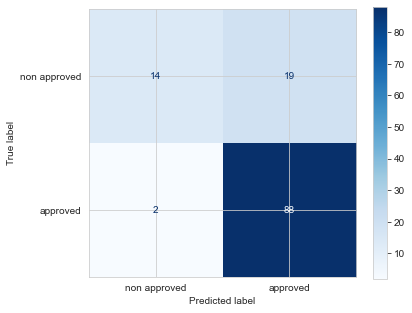

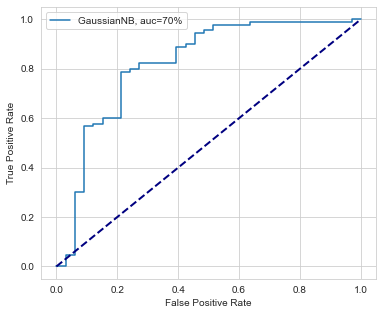




=================== KNeighborsClassifier ===================
              precision    recall  f1-score   support

           0       0.41      0.55      0.47        33
           1       0.81      0.71      0.76        90

    accuracy                           0.67       123
   macro avg       0.61      0.63      0.61       123
weighted avg       0.70      0.67      0.68       123

[[18 15]
 [26 64]]
KNeighborsClassifier roc: 62.83%
[0.7184466  0.66990291 0.59803922 0.65686275 0.54901961 0.66666667]
0.64 accuracy with a standard deviation of 0.05


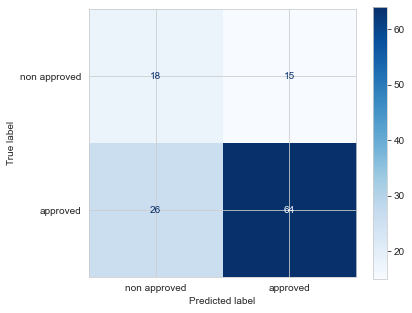

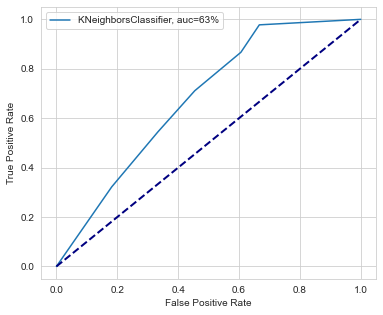




==================== LogisticRegression ====================
              precision    recall  f1-score   support

           0       0.64      0.55      0.59        33
           1       0.84      0.89      0.86        90

    accuracy                           0.80       123
   macro avg       0.74      0.72      0.73       123
weighted avg       0.79      0.80      0.79       123

[[18 15]
 [10 80]]
LogisticRegression roc: 71.72%
[0.82524272 0.76699029 0.7745098  0.81372549 0.83333333 0.83333333]
0.81 accuracy with a standard deviation of 0.03


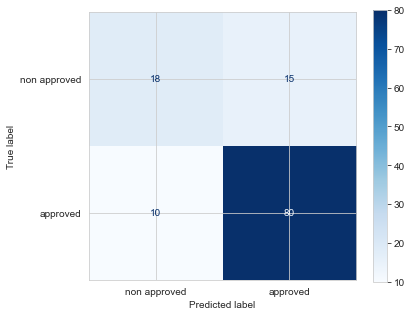

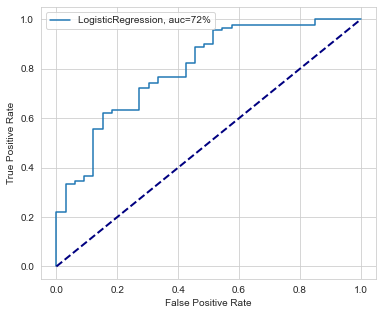




=========================== SVC ============================
              precision    recall  f1-score   support

           0       0.39      0.27      0.32        33
           1       0.76      0.84      0.80        90

    accuracy                           0.69       123
   macro avg       0.58      0.56      0.56       123
weighted avg       0.66      0.69      0.67       123

[[ 9 24]
 [14 76]]
SVC roc: 55.86%
[0.68932039 0.68932039 0.67647059 0.69607843 0.70588235 0.68627451]
0.69 accuracy with a standard deviation of 0.01


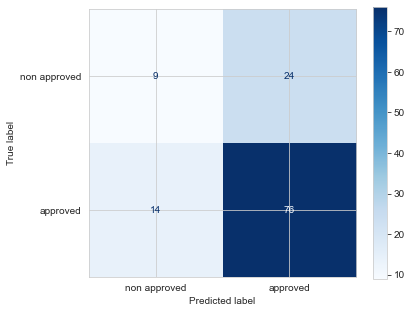

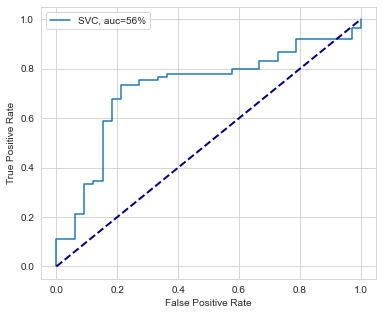

In [147]:
for classifier in classifiers:
  show_details(X_test, Y_test, classifier, cv=cv_generator)

Training roc curve


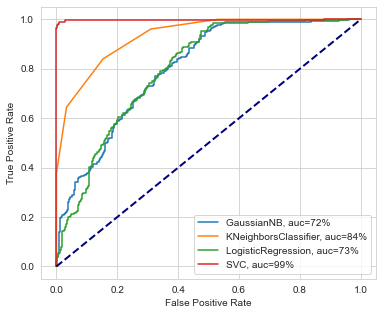



Testing roc curve


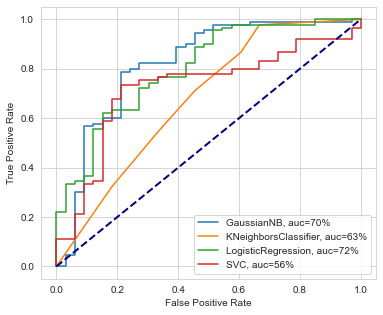

In [148]:
print("Training roc curve")
build_auc_plot(classifiers, X_train, Y_train)

print("\n\nTesting roc curve")
build_auc_plot(classifiers, X_test, Y_test)